In [1]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("../secrets/spatial-interaction-project-b528921f271f.json")

In [2]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [4]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

def get_edges(fips, dataset, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("dataset", "STRING", dataset),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                SAFE_CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `spatial-interaction-project.safegraph.{dataset}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) IN {fips} AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})
    
    edges = edges[~edges['weight'].isnull()]

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

def get_graph(edges, nodes, method='direct'):
    if method == 'bundled':
        print('Bundling desire lines...')
        return hammer_bundle(nodes, edges,
                             source='focal', target='target',
                             decay=0.25,
                             x='X', y='Y')
    else:
        print('Linking desire lines...')
        return connect_edges(nodes, edges,
                             source='focal', target='target',
                             x='X', y='Y')

In [5]:
boros = ["36061", "36085", "36047", "36005", "36081"]

nodes = list()
shape = list()

for fips in boros:
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

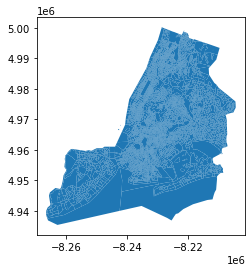

In [6]:
shape.plot()

In [7]:
fips_tuple = tuple(boros)

In [12]:
def get_edges(fips, month, cbgs):

    print(month)
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                SAFE_CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `spatial-interaction-project.safegraph.{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) IN {fips} AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})
    
    edges = edges[~edges['weight'].isnull()]

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

In [13]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years  = ["2019", "2020", "2021"]

full_range = np.concatenate([[ y + "_" + m for m in months] for y in years])

In [14]:
datasets = full_range[12:30]

In [15]:
%%time
edges = list()

for dataset in datasets:
        
        temp = get_edges(fips_tuple, dataset, nodes.index)
        temp['month'] = dataset
        
        edges.append(temp)

edges = pd.concat(edges, ignore_index=True)

2020_01
2020_02
2020_03
2020_04
2020_05
2020_06
2020_07
2020_08
2020_09
2020_10
2020_11
2020_12
2021_01
2021_02
2021_03
2021_04
2021_05
2021_06
CPU times: user 52.9 s, sys: 3.16 s, total: 56.1 s
Wall time: 4min 17s


In [16]:
edges.head()

,focal,target,weight,month
0,360470205002,360470205002,71,2020_01
1,360470199002,360470199003,58,2020_01
2,360470227004,360470305001,34,2020_01
3,360470227004,360470227001,59,2020_01
4,360470233003,360470259021,14,2020_01


In [17]:
scico = pd.read_csv("https://raw.githubusercontent.com/asrenninger/palettes/master/scico_wide.csv")

In [20]:
import re

In [25]:
def nodesplot(nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.points(nodes,'X','Y',agg=None)
    spr = tf.spread(tf.shade(agg, cmap=list(scico.hawaii.array)[10]), px=8)
    
    return spr

def edgesplot(nodes, edges):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.line(edges, 'X','Y', agg=ds.count())
    spr = tf.shade(agg, cmap=list(scico.hawaii.array), how='eq_hist')
    
    return spr

def combiplot(nodes, edges):
    
    verts = nodesplot(nodes)
    links = edgesplot(nodes, edges)
    
    stack = tf.stack(verts, links)
    
    ready = tf.set_background(stack, '#000000')
    
    return ready.to_pil()

def plot_graphs_by_month(fig, data, nodes, dataset, x_range, y_range):
    
    temp = data[data['month']==dataset].drop('month', axis=1)
    
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.05,
        0.9,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    year, month = re.split("_", dataset)
    
    months = ['January', 'February', 'March', 
              'April', 'May', 'June', 
              'July', 'August', 'September',
              'October', 'November', 'December']
    
    ax.text(
        0.15,
        0.85,
        months[int(month)-1],
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    ax.text(
        0.05,
        0.85,
        year,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)
    
    network = nx.from_pandas_edgelist(temp, 'focal', 'target', ['weight'])
    
    density.append(nx.density(network))
    
    sub = plt.axes([0.07, 0.7, 0.25, 0.1], facecolor='#000000')
    sub.step(x=np.arange(1, len(density) + 1), y=density, color='#ffffff')
    
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#000000') 
    ax.spines['right'].set_color('000000')
    ax.spines['left'].set_color('000000')
    
    plt.title('network density', weight='bold', color='#ffffff', position=(0.2, 0)) 

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

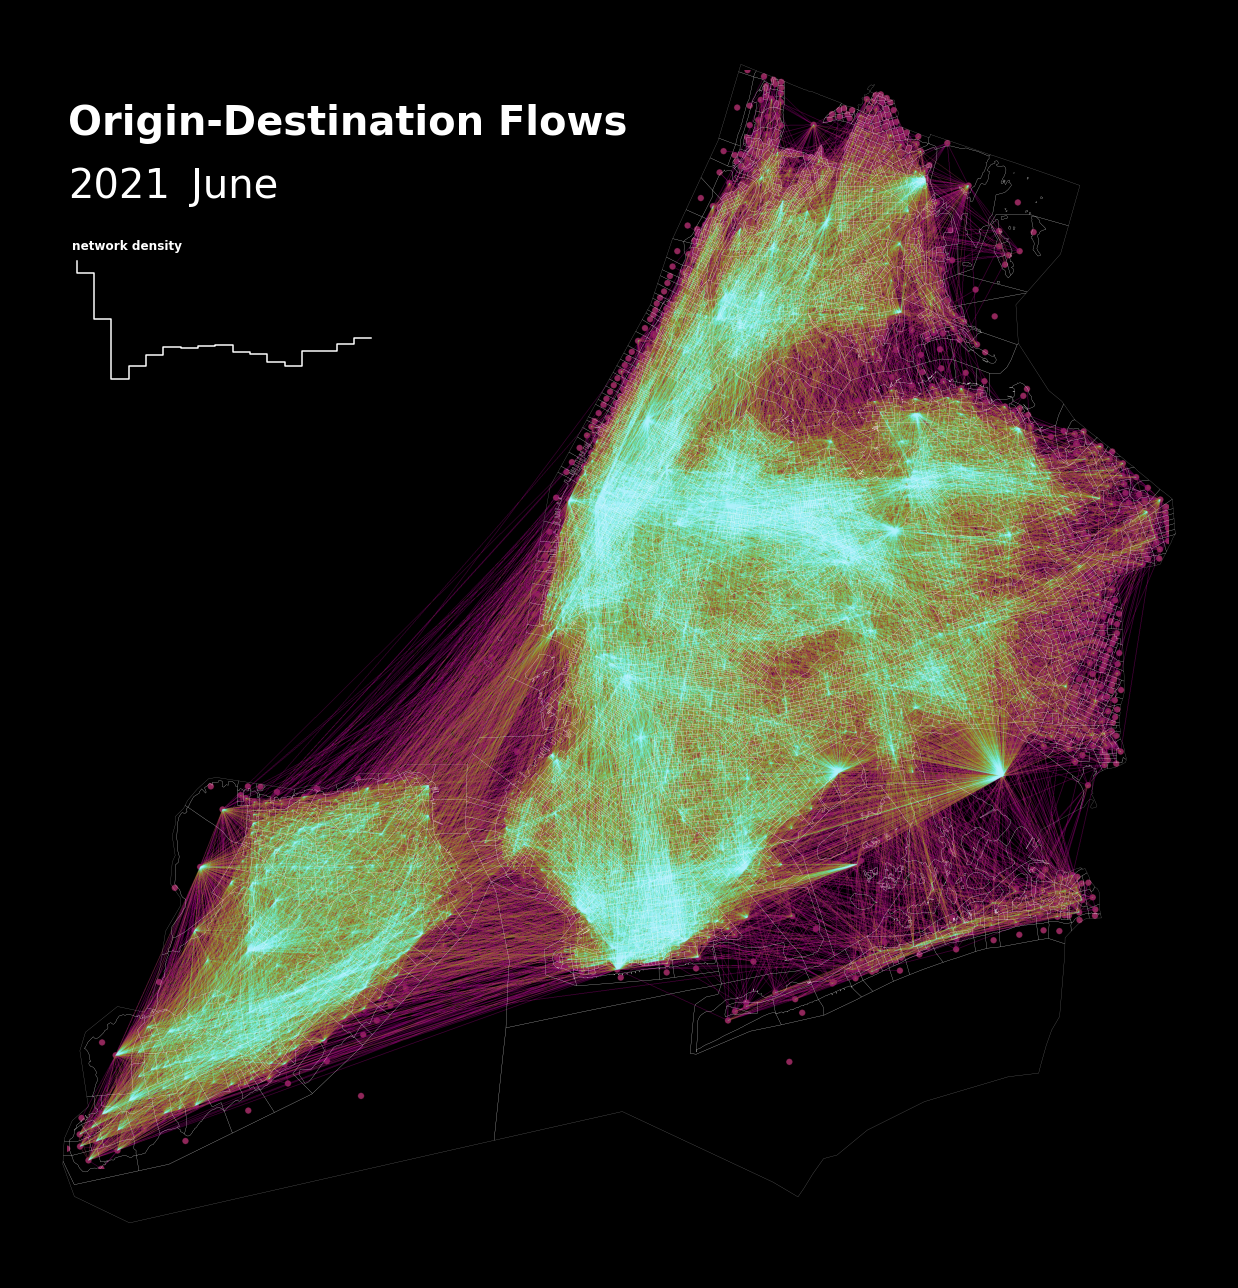

In [26]:
bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]

imgs = []
density = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(edges.month.unique()):
    
    img = plot_graphs_by_month(fig, edges, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('nyc_hawaii.gif', imgs, fps=1);

In [78]:
density = []

for period in np.sort(edges.month.unique()):
    
    temps = edges[edges['month']==period]
    graph = nx.from_pandas_edgelist(temps, 'focal', 'target', ['weight'])
    
    density.append(nx.density(graph))

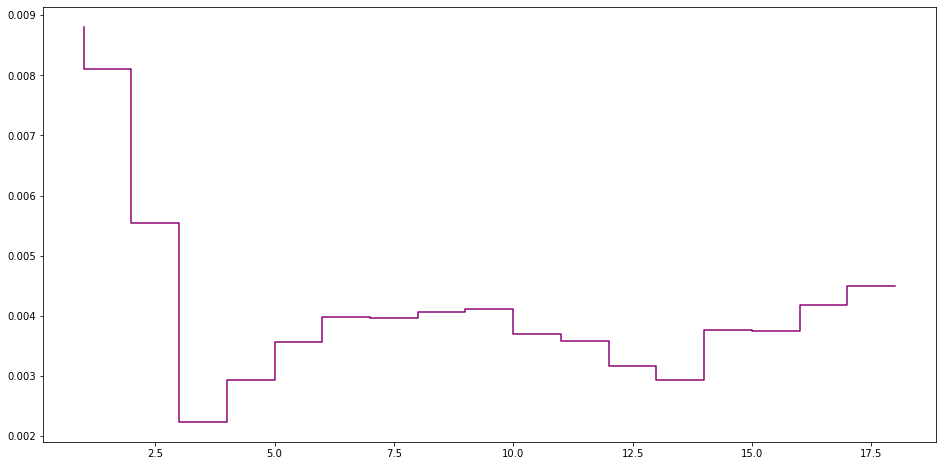

In [79]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.step(x=np.arange(1, len(density) + 1), y=density, color=scico.hawaii[0])

In [47]:
edges['poi_county'] = edges.target.astype('str').str.slice(stop=5)
edges['home_county'] = edges.focal.astype('str').str.slice(stop=5)

In [48]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

In [49]:
metros.head()

,metro_fips,metro_name,county_fips,county_name
0,10180,"Abilene, TX (Metropolitan Statistical Area)",48059,"Callahan, TX"
1,10180,"Abilene, TX (Metropolitan Statistical Area)",48253,"Jones, TX"
2,10180,"Abilene, TX (Metropolitan Statistical Area)",48441,"Taylor, TX"
3,10420,"Akron, OH (Metropolitan Statistical Area)",39133,"Portage, OH"
4,10420,"Akron, OH (Metropolitan Statistical Area)",39153,"Summit, OH"


In [50]:
nyc = metros[(metros.metro_name.str.contains('New York'))]
nyc = nyc[nyc.county_fips.isin(boros)]

nyc.head()

,metro_fips,metro_name,county_fips,county_name
759,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",36005,"Bronx, NY"
760,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",36047,"Kings, NY"
762,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",36061,"New York, NY"
764,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",36081,"Queens, NY"
765,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",36085,"Richmond, NY"


In [51]:
nyc['county'] = nyc.county_fips.astype('str').str.pad(fillchar="0", side='left', width=5)
nyc['county_name'] = nyc.county_name.str.replace(", NY", "")

merged = edges.merge(nyc, left_on='poi_county', right_on='county', how='left')
merged = merged[merged['poi_county']==merged['home_county']]

In [52]:
names = merged.county_name.unique()

densities = list()

for name in names:
    
    density = []
    
    for period in np.sort(edges.month.unique()):
        
        temps = merged[(merged['county_name']==name) & (merged['month']==period)]
        graph = nx.from_pandas_edgelist(temps, 'focal', 'target', ['weight'])
    
        density.append(nx.density(graph))
        
    density = pd.DataFrame({'name': name,
                            'density': density})
    
    densities.append(density)
    
densities = pd.concat(densities, ignore_index=True)    

Text(0.5, 0.05, 'Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.')

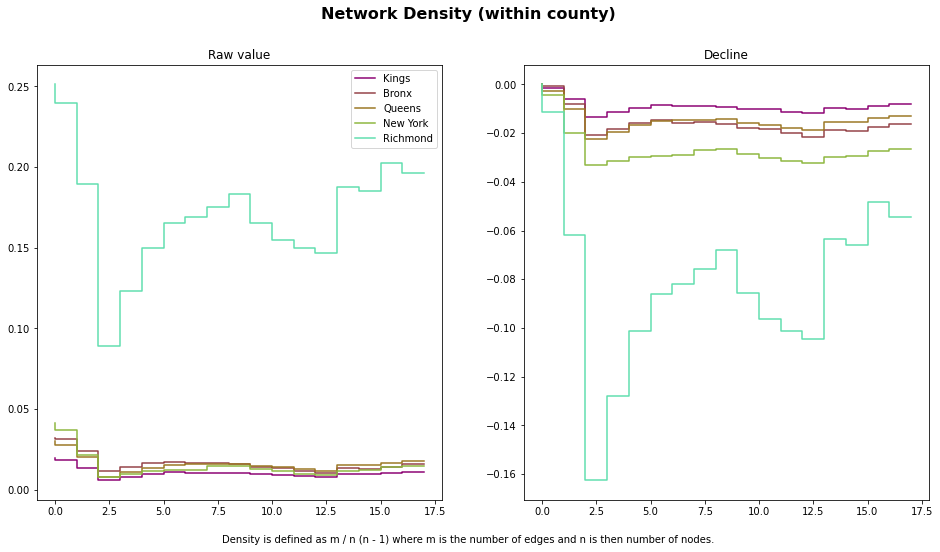

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

import random
pal = scico.hawaii[np.arange(0, scico.hawaii.shape[0], step = (scico.hawaii.shape[0] // nyc.shape[0]))].to_numpy()

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[0].set_title('Raw value')
    axs[0].step(x=temp.index, y=temp['density'], color=pal[i], label=labs[i])

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[1].set_title('Decline')
    axs[1].step(x=temp.index, y=temp['density'] - temp['density'].max(), color=pal[i], label=labs[i])
    
axs[0].legend()

fig.suptitle('Network Density (within county)', fontsize=16, weight='bold')
fig.text(0.5, 0.05, "Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.", ha='center')